<a href="https://colab.research.google.com/github/marcomedugno/Personal-Projects/blob/main/Survival_Prediction_in_Hepatocellular_Carcinoma_Patients_Using_Clinical_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Survival Prediction in Hepatocellular Carcinoma Patients Using Clinical Data**

*by Marco Medugno*

## **Overview**

**Hepatocellular carcinoma (HCC)** is one of the most common and deadly forms of liver cancer. Timely prediction of survival outcomes is critical for triaging patients into high- vs low-risk care pathways. In this project, I built a predictive model for **1-year survival** using real clinical data from 165 patients at a university hospital in Portugal. The dataset includes 49 clinical, demographic, and lab features aligned with **EASL-EORTC guidelines** for managing HCC.

In [2]:
# @title
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import shap

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# @title
# Load the HCC Dataset
file_path = "hcc-data.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mrsantos/hcc-dataset",
    file_path,
)

# Replace "?" with np.nan and convert all to numeric
df.replace("?", np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# Set column names from hcc-description.txt
column_names = [
    "Gender", "Symptoms", "Alcohol", "HBsAg", "HBeAg", "HBcAb", "HCVAb",
    "Cirrhosis", "Endemic", "Smoking", "Diabetes", "Obesity", "Hemochro", "AHT",
    "CRI", "HIV", "NASH", "Varices", "Spleno", "PHT", "PVT", "Metastasis", "Hallmark",
    "Age", "Grams_per_day", "Packs_per_year", "Performance_Status", "Encephalopathy",
    "Ascites", "INR", "AFP", "Hemoglobin", "MCV", "Leucocytes", "Platelets", "Albumin",
    "Total_Bilirubin", "ALT", "AST", "GGT", "ALP", "Total_Proteins", "Creatinine",
    "Nodules", "Major_Dim", "Direct_Bilirubin", "Iron", "Oxygen_Saturation",
    "Ferritin", "Survival"
]

df.columns = column_names

# Preview cleaned data
df.head()


100%|██████████| 22.2k/22.2k [00:00<00:00, 2.64MB/s]


,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,...,ALP,Total_Proteins,Creatinine,Nodules,Major_Dim,Direct_Bilirubin,Iron,Oxygen_Saturation,Ferritin,Survival
0,0,NaN,0,0.0,0.0,0.0,1.0,1,NaN,NaN,...,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,1
1,1,0.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,...,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1
2,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,...,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,0
3,1,1.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,...,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,1
4,1,0.0,1,0.0,NaN,0.0,0.0,1,0.0,NaN,...,396.0,5.6,0.90,1.0,10.0,1.4,53.0,22.0,111.0,0


## **Data Cleaning & Feature Categorization**

The raw dataset had ~10% missing data and included both **continuous labels** (e.g. albumin, bilirubin), **binary clinical indicators** (e.g. HBsAg, ascites), and **ordinal performance measures** (e.g. ECOG status). These were handled using the following preprocessing rules:


*   **Median imputation** for continuous variables
*   **Mode imputation** for binary/ordinal variables

The preprocessing pipeline ensured that clinical structure and interpretability were preserved.


In [4]:
# @title
# Define feature categories
binary_features = [
    "Gender", "Symptoms", "Alcohol", "HBsAg", "HBeAg", "HBcAb", "HCVAb", "Cirrhosis",
    "Endemic", "Smoking", "Diabetes", "Obesity", "Hemochro", "AHT", "CRI", "HIV", "NASH",
    "Varices", "Spleno", "PHT", "PVT", "Metastasis", "Hallmark"
]

ordinal_features = {
    "Performance_Status": [0, 1, 2, 3, 4],
    "Ascites": [1, 2, 3],
    "Encephalopathy": [1, 2, 3]
}

continuous_features = [col for col in df.columns if col not in binary_features and col not in ordinal_features and col != "Survival"]


In [5]:
# @title
# Imputers
binary_imputer = SimpleImputer(strategy='most_frequent')
ordinal_imputer = SimpleImputer(strategy='most_frequent')
cont_imputer = SimpleImputer(strategy='median')

# Impute groups
df_bin = pd.DataFrame(binary_imputer.fit_transform(df[binary_features]), columns=binary_features)
df_ord = pd.DataFrame(ordinal_imputer.fit_transform(df[list(ordinal_features.keys())]), columns=ordinal_features.keys())
df_cont = pd.DataFrame(cont_imputer.fit_transform(df[continuous_features]), columns=continuous_features)

# Combine back
X = pd.concat([df_bin, df_ord, df_cont], axis=1)
y = df['Survival']


In [6]:
# @title
ordinal_encoder = OrdinalEncoder(categories=[ordinal_features[feat] for feat in ordinal_features])
df_ord_encoded = pd.DataFrame(
    ordinal_encoder.fit_transform(df_ord),
    columns=ordinal_features.keys()
)

In [7]:
# @title
X = pd.concat([df_bin, df_ord_encoded, df_cont], axis=1)

## **Model Training & Evaluation**

To predict 1-year survival, I trained a **Random Forest classifier**, a model well-suited for handling non-linear clinical data and mixed feature types (e.g. labs, comorbidities, and scores). The dataset had a modest class imbalance (102 patients survived, while 63 did not). To address this, I applied class_weight='balanced', which adjusts the algorithm to pay proportionally more attention to the underrepresented class (in this case, patients who died). In clinical machine learning, class imbalance can severely impact model reliability, especially when the minority class represents high-risk patients. If the model underperforms on this group, it may fail to identify those who need urgent care, leading to missed interventions and worse outcomes. Moreover, over-predicting risk can cause alert fatigue in clinical dashboards, reducing trust in the system and increasing the chance that true positives are overlooked. Balancing class weights ensures more equitable attention to all patient outcomes.

I used a **stratified train/test split**, ensuring both survival and death cases were proportionally represented in the test set. The model was evaluated on 33 held-out patients using metrics that reflect both discriminative power and real-world clinical relevance:

*   **Accuracy**: 70%
*   **AUC-ROC**: 0.70
*   **F1 (survivors)**: 0.74

While these metrics are competitive in a general data science context, they're even more meaningful in a clinical setting. In hepatocellular carcinoma, traditional scoring systems like **BCLC**, **ALBI**, or **CLIP** tend to achieve [AUCs in the range of **0.66 to 0.74**](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0216173). These scores are rule-based and easy to apply at the bedside, but they don't learn from new data or capture complex feature interactions.

In contrast, my model learns from a broader range of features, adapts over time, and remains interpretable through SHAP values. It achieves similar predictive performance to these established clinical tools, while also offering scalability, customizability, and the ability to be integrated into real-time clinical decision systems or population health dashboards.


In [8]:
# @title
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [9]:
# @title
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.60      0.69      0.64        13
           1       0.78      0.70      0.74        20

    accuracy                           0.70        33
   macro avg       0.69      0.70      0.69        33
weighted avg       0.71      0.70      0.70        33

ROC AUC Score: 0.7019230769230769


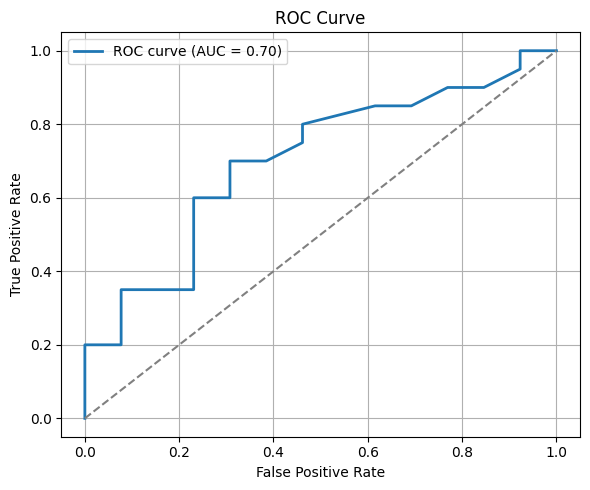

In [10]:
# @title
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Interpreting Predictions with SHAP**

To ensure the model's decisions were clinically grounded, I used **SHAP (SHapley Additive exPlanations)** to interpret feature contributions, allowing me to examine the global importance of each variable.

The top predictive features were:

*   **ALP (Alkaline Phosphatase)**: elevated in biliary obstruction and tumor progression
*   **Hemoglobin**: lower levels may reflect anemia of chronic disease or liver dysfunction
*   **AFP (Alpha-Fetoprotein)**: a widely used tumor marker for HCC
*   **Performance Status (ECOG)**: a direct measure of patient frailty and functionality
*   **Albumin, Ferritin, Direct Bilirubin, and Ascites**: markers of liver reserve and disease severity

These features align with published HCC survival studies and clinical experience. Their inclusion validates that the model's predictions reflect medically relevant signals.




In [11]:
# @title
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Extract shape: (n_samples, n_features)
shap_values_class1 = shap_values[:, :, 1]

# Average absolute SHAP impact across patients
shap_mean = np.abs(shap_values_class1).mean(axis=0)

# Create a ranked Series
shap_ranking = pd.Series(shap_mean, index=X_test.columns).sort_values(ascending=False)

print("Top 10 most impactful features for predicting survival:")
print(shap_ranking.head(10))


Top 10 most impactful features for predicting survival:
ALP                   0.063523
Hemoglobin            0.047370
AFP                   0.038921
Performance_Status    0.036243
Ferritin              0.031387
Iron                  0.022594
Albumin               0.021319
Direct_Bilirubin      0.018383
Age                   0.017442
Ascites               0.016849
dtype: float64


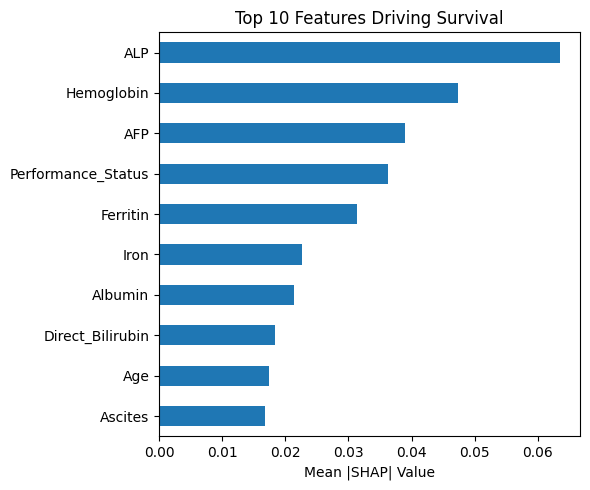

In [12]:
# @title
shap_ranking.head(10).plot(kind='barh', figsize=(6,5), title="Top 10 Features Driving Survival")
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP| Value")
plt.tight_layout()
plt.show()


## **Conclusion**

This project shows how interpretable machine learning can complement clinical practice in predicting 1-year survival for HCC patients. The model's performance aligns with traditional scoring systems, while offering greater flexibility and insight through feature-level explanations. By surfacing key clinical predictors and handling real-world data challenges, this approach highlights the potential for data science to support risk stratification and care prioritization in oncology-focused population health initiatives.